# SLASH Slot Attention Shapeworld4 experiment test notebook

In [1]:
import time
import sys
sys.path.append('../')
sys.path.append('../../../')
sys.path.append('../../../SLASH/')
sys.path.append('../../../EinsumNetworks/src/')


#torch, numpy, ...
import torch
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import importlib
import matplotlib.pyplot as plt

#plt.style.use(["science"])  # Need SciencePlots pip package

import matplotlib
matplotlib.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": False,
    }
)


import utils
import ap_utils
import os

from slash import SLASH
from dataGen import get_loader, get_data_and_object_list, SHAPEWORLD4
from tqdm.notebook import tqdm

from einsum_wrapper import EiNet
from slot_attention_module import SlotAttention_model, NPP_SlotAttention_classifier



A detection is considered a **true positive** if the discrete predicted properties (obtained with an argmax) exactly match the ground truth. 
- This excludes predicting the correct background object
- If we predict two blue spheres but only have one blue sphere as our ground truth we get one true positve and one false positve

A detection is considered a **false positive** if the discrete predicted properties (obtained with an argmax) do not exactly match the ground truth.
- If we predict an object with either shape background or color black this is considered a false positive.

A detection is considered a **true negative** if the background is predicted correctly.
- We have one background prediction for each sample
- If we predict two background objects we would get one true negative and one false negative




In [2]:
#MODEL = "most_probable_with_slot_with_lr_decay"
MODEL = "shapeworld4_ablation4_1024"
#data/one_to_one_pretrained_test_2/slash_slot_models.pt
class_count = 3
num_slots = 4
bg_encoded = False


model_path = "data/"+MODEL+"/slash_slot_models.pt" 
models = torch.load(model_path)

exp_dict = models['exp_dict']
print(exp_dict)

print(models.keys())
program = models['program']

#setup new SLASH program given the network parameters
if exp_dict['structure'] == 'poon-domingos':
    exp_dict['depth'] = None
    exp_dict['num_repetitions'] = None
    print("using poon-domingos")

elif exp_dict['structure'] == 'binary-trees':
    exp_dict['pd_num_pieces'] = None
    print("using binary-trees")


#NETWORKS

#color network
    # color network
color_net = NPP_SlotAttention_classifier(in_channels=32, out_channels=9)

# shape network
shape_net = NPP_SlotAttention_classifier(in_channels=32, out_channels=4)

# shade network
shade_net = NPP_SlotAttention_classifier(in_channels=32, out_channels=3)

# size network
size_net = NPP_SlotAttention_classifier(in_channels=32, out_channels=3)
    
#create the Slot Attention network
slot_net = SlotAttention_model(n_slots=num_slots, n_iters=3, n_attr=18,
                                encoder_hidden_channels=32, attention_hidden_channels=64,
                                decoder_hidden_channels=32, decoder_initial_size=(32, 32)).to(device='cuda')# was 32*32 and 128



#load all model parts
#shape_net.load_state_dict(models['shape_net'])
#color_net.load_state_dict(models['color_net'])
#shade_net.load_state_dict(models['shade_net'])
#size_net.load_state_dict(models['size_net'])

#slot_net.load_state_dict(models['slot_net'])




s_params = list(shape_net.parameters()) + list(slot_net.parameters())
c_params = list(color_net.parameters()) + list(slot_net.parameters())


#create the SLASH Program
nnMapping = {'color': color_net,
                 'shape':shape_net,
                 'shade':shade_net,
                 'size':size_net}
optimizers = {'color': torch.optim.Adam(c_params, lr=0.0004, eps=1e-7),
              'shape':torch.optim.Adam(s_params, lr=0.004, eps=1e-7)}
SLASHobj = SLASH(program, nnMapping, optimizers)

{'structure': 'poon-domingos', 'pd_num_pieces': [4], 'bs': 512, 'epochs': 1100, 'lr_warmup_steps': 8, 'lr_decay_steps': 368, 'start_date': '23-01-2022', 'resume': False, 'credentials': 'DO', 'seed': 1, 'p_num': 8, 'explanation': 'Running the whole SlotAttention+Slash pipeline using poon-domingos as SPN structure learner.', 'depth': None, 'num_repetitions': None}
dict_keys(['shape_net', 'color_net', 'shade_net', 'size_net', 'slot_net', 'resume', 'test_ll_list', 'test_ap_list', 'loss_list', 'temp_elements_list', 'temp_prob_sum_list', 'temp_gradient_sum_list', 'test_metric_list', 'lr_list', 'num_params', 'time', 'exp_dict', 'program'])
using poon-domingos


In [ ]:
#self.mvpp['program'], self.mvpp['program_pr'], self.mvpp['program_asp'] = self.parse(query='')

print(SLASHobj.mvpp['program_pr'])

print("\n\n")
print(SLASHobj.mvpp['program_asp'])

NameError: name 'SLASHobj' is not defined

# Model predictions

In [ ]:
dataList, queryList, objList = get_data_and_object_list(SHAPEWORLD4('../../data/shapeworld4/',"val"), 1, shuffle=False)
print(len(dataList), len(queryList))

inference, out = SLASHobj.forward_slot_attention_pipeline(slot_net=slot_net, data_batch= dataList[5])



100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

5000 5000


NameError: name 'SLASHobj' is not defined

In [ ]:
def interpret_inference(inference,print_query =True):

    
    inference_list = []
    
    """
    pc(color(1,X),[red, blue, green, gray, brown, magenta, cyan, yellow, black]) :- slot(X).
    pc(shape(1,X),[circle, triangle, square, bg]) :- slot(X).
    pc(shade(1,X),[bright, dark, bg]) :- slot(X).
    pc(size(1,X),[small, big, bg]) :- slot(X)."""
    
    
    for slot in inference:
        shape = inference[slot]['shape']
        color = inference[slot]['color']
        shade = inference[slot]['shade']
        size = inference[slot]['size']

        sid = torch.argmax(shape)
        cid = torch.argmax(color)
        hid = torch.argmax(shade)
        xid = torch.argmax(size)
        
        s=''
        c=''
        h=''
        x=''
        
        #print(sid, cid)
        if cid == 0:
            c= 'red'
        elif cid == 1:
            c= 'blue'
        elif cid == 2:
            c= 'green'
        elif cid == 3:
            c= 'gray'
        elif cid == 4:
            c= 'brown'
        elif cid == 5:
            c= 'magenta'            
        elif cid == 6:
            c= 'cyan'            
        elif cid == 7:
            c= 'yellow'            
        elif cid == 8:
            c= 'black'
            
        if sid == 0:
            s='circle'
        elif sid == 1:
            s='triangle'
        elif sid == 2:
            s='square'
        elif sid == 3:
            s='bg'    
      
                    
        if hid == 0:
            h='bright'
        elif hid == 1:
            h='dark'
        elif hid == 2:
            h='bg'
             
                    
        if xid == 0:
            x='small'
        elif xid == 1:
            x='big'
        elif xid == 2:
            x='bg'
        
        if print_query:
            print("there is a {} {} {} {} in the image.".format(x, h, c, s))
        
        #if c != 'black' and s != 'bg': 
        inference_list.append([c, s])
    
    return inference_list

### Model tell us what we see in the image! 

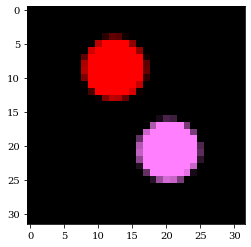

trained with query string:
:- not object(o1,red,circle,bright,big). :- not object(o2,magenta,circle,dark,big). :- not object(o3,black,bg, bg, bg). :- not object(o4,black,bg, bg, bg). 
The model says:
there is a big dark red triangle in the image.
there is a small dark red triangle in the image.
there is a bg bg red bg in the image.
there is a small dark red circle in the image.

with probabilities:
   red,    blue,  green, gray,  brown,magenta,cyan, yellow, black, circle, triangle, square, bg
s0 [0.715, 0.029, 0.021, 0.000, 0.008, 0.013, 0.056, 0.157, 0.000] [0.255, 0.503, 0.196, 0.045]
s1 [0.608, 0.023, 0.023, 0.000, 0.011, 0.016, 0.116, 0.203, 0.000] [0.230, 0.548, 0.194, 0.027]
s2 [0.789, 0.089, 0.048, 0.000, 0.008, 0.008, 0.017, 0.040, 0.000] [0.111, 0.134, 0.200, 0.555]
s3 [0.589, 0.126, 0.110, 0.000, 0.005, 0.006, 0.102, 0.062, 0.000] [0.351, 0.227, 0.120, 0.303]
   bright, dark,  bg,     small, big,   bg
s0 [0.167, 0.808, 0.025] [0.473, 0.475, 0.052]
s1 [0.115, 0.872, 0.013] [0.

In [ ]:
idx = int(np.random.rand()* len(dataList))

idx = 4156


#plot the image
img = np.einsum("abc->bca",dataList[idx]['im'].cpu().numpy().squeeze())

#with plt.style.context('dark_background'):
plt.imshow((img+1)/2)


plt.show()


print("trained with query string:")
print(queryList[idx])


#get the predictions of what is in the image
inference, out = SLASHobj.forward_slot_attention_pipeline(slot_net=slot_net, data_batch= dataList[idx])

print("The model says:")
interpret_inference(inference)


print("\nwith probabilities:")

print("   red,    blue,  green, gray,  brown,magenta,cyan, yellow, black, circle, triangle, square, bg")

for slot in inference.keys():
    
    color = ("["+', '.join(['%.3f']*9)+"]") % tuple(inference[slot]['color'].cpu().numpy()[0])
    shape = ("["+', '.join(['%.3f']*4)+"]") % tuple(inference[slot]['shape'].cpu().numpy()[0])
    print(slot,color,shape)
    
print("   bright, dark,  bg,     small, big,   bg")

for slot in inference.keys():
    shade = ("["+', '.join(['%.3f']*3)+"]") % tuple(inference[slot]['shade'].cpu().numpy()[0])
    size = ("["+', '.join(['%.3f']*3)+"]") % tuple(inference[slot]['size'].cpu().numpy()[0])
    print(slot,shade,size)
    
 
print("\n Our GT is:\n",queryList[idx])



### Average precision values

In [ ]:
dataListArray = np.array(dataList)
inference, _ = SLASHobj.forward_slot_attention_pipeline(slot_net=slot_net, data_batch= dataListArray[:])


target = np.array(objList)

#compute the average precision, tp, fp, tn for color+shape, color, shape
pred = ap_utils.inference_map_to_array(inference).cpu().numpy()



print(pred.shape,target.shape)

ap, true_positives, false_positives, true_negatives, correctly_classified = ap_utils.average_precision(pred, target,-1, "SHAPEWORLD4")
print("avg precision ",ap, "tp", true_positives, "fp", false_positives, "tn", true_negatives, "correctly classified",correctly_classified)


#color
pred_c = ap_utils.inference_map_to_array(inference, only_color=True).cpu().numpy()
ap_c, true_positives_c, false_positives_c, true_negatives_c, correctly_classified_c  = ap_utils.average_precision(pred, target,-1, "SHAPEWORLD4", only_color = True)
print("avg precision color",ap_c, "tp", true_positives_c, "fp", false_positives_c, "tn", true_negatives_c, "correctly classified",correctly_classified_c)

#shape              
pred_s = ap_utils.inference_map_to_array(inference, only_shape=True).cpu().numpy()
ap_s, true_positives_s, false_positives_s, true_negatives_s, correctly_classified_s= ap_utils.average_precision(pred_s, target,-1, "SHAPEWORLD4", only_shape = True)
print("avg precision shape",ap_s, "tp", true_positives_s, "fp", false_positives_s, "tn", true_negatives_s, "correctly classified",correctly_classified_s)

#shade              
pred_h = ap_utils.inference_map_to_array(inference, only_shade=True).cpu().numpy()
ap_h, true_positives_h, false_positives_h, true_negatives_h, correctly_classified_h= ap_utils.average_precision(pred_h, target,-1, "SHAPEWORLD4", only_shade = True)
print("avg precision shade",ap_h, "tp", true_positives_h, "fp", false_positives_h, "tn", true_negatives_h, "correctly classified",correctly_classified_h)

#shape              
pred_x = ap_utils.inference_map_to_array(inference, only_size=True).cpu().numpy()
ap_x, true_positives_x, false_positives_x, true_negatives_x, correctly_classified_x= ap_utils.average_precision(pred_x, target,-1, "SHAPEWORLD4", only_size = True)
print("avg precision size",ap_x, "tp", true_positives_x, "fp", false_positives_x, "tn", true_negatives_x, "correctly classified",correctly_classified_x)

(5000, 4, 20) (5000, 4, 20)
avg precision  0.00016811763365655492 tp 250.0 fp 19750.0 tn 0.0 correctly classified 0
avg precision color 0.017205355274744642 tp 1718.0 fp 18282.0 tn 0.0 correctly classified 0
avg precision shape 0.38492747427610147 tp 11220.0 fp 8780.0 tn 0.0 correctly classified 288
avg precision shade 0.45924106854962365 tp 12390.0 fp 7610.0 tn 0.0 correctly classified 521
avg precision size 0.47839214459764734 tp 12743.0 fp 7257.0 tn 0.0 correctly classified 601


## Log Likelihoods
circle 0, triangle 1, square 2
red 0, blue 1, green 2
            

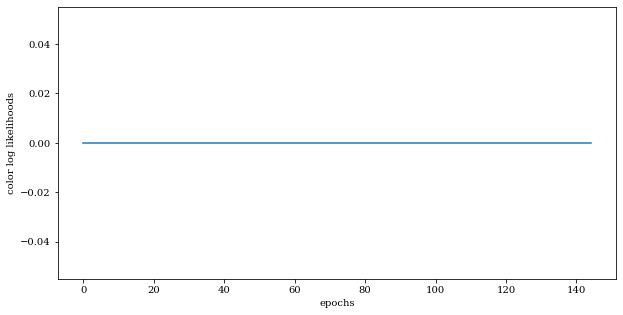

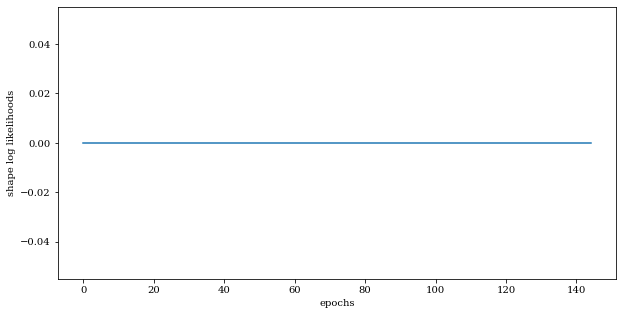

In [ ]:
test_ll_list = models['test_ll_list']

temp= np.zeros((len(test_ll_list), 3))


for i, ll in enumerate(test_ll_list):
    temp[i,0] = ll[1]
    temp[i,1] = ll[0][0]
    temp[i,2] = ll[0][1]

x = temp.shape[0]
x= 250
sign = -1

    
fig = plt.figure(figsize=(10,5))    
plt.plot(temp[:x,0], sign*temp[:x,1], label="c")
plt.xlabel("epochs")
plt.ylabel("color log likelihoods")
plt.show()

fig = plt.figure(figsize=(10,5))    
plt.plot(temp[:x,0], sign*temp[:x,2])
plt.xlabel("epochs")
plt.ylabel("shape log likelihoods")
plt.show()

plt.show()



# Average Precision plots

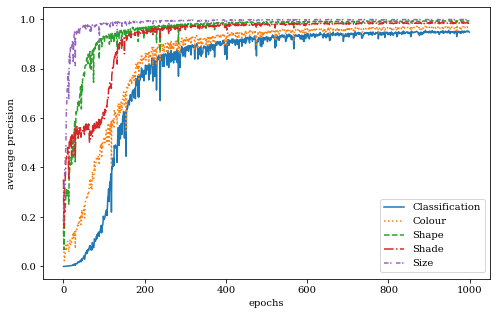

0.9541789677099057



In [3]:
test_ap_list = models['test_ap_list']
test_ap_list = np.array(test_ap_list)


x= 1000


fig, ax = plt.subplots(1, figsize=(8,5))


ax.set_xlabel("epochs")
ax.set_ylabel("average precision")

#ap, ap_c, ap_s, ap_h, ap_x, e

ax.plot(test_ap_list[:x,5], test_ap_list[:x,0], label="Classification", linestyle='solid')
ax.plot(test_ap_list[:x,5], test_ap_list[:x,1], label="Colour", linestyle='dotted')
ax.plot(test_ap_list[:x,5], test_ap_list[:x,2], label="Shape", linestyle='dashed')
ax.plot(test_ap_list[:x,5], test_ap_list[:x,3], label="Shade", linestyle='dashdot')
ax.plot(test_ap_list[:x,5], test_ap_list[:x,4], label="Size", linestyle=(0,(3,1,1,3)))


directory = os.path.dirname("plots/")
try:
    os.stat(directory)
except:
    os.mkdir(directory)
fig.legend(loc='lower right', bbox_to_anchor=(0.5, 0.13, 0.4, 0.2))
fig.savefig('plots/ap_shapeworld4.png', format="png")
fig.savefig('plots/ap_shapeworld4.svg', format="svg")


plt.show()


print(np.max(test_ap_list[:x,0]))
print()

# Loss

[ 5.67410111e-01  5.26822269e-01  4.83507812e-01  4.99471426e-01
  4.62392807e-01  4.39837843e-01  4.20990378e-01  4.36419070e-01
  4.21340942e-01  3.91285747e-01  4.42632914e-01  4.05033290e-01
  3.84393126e-01  3.76063526e-01  4.10844505e-01  3.28563303e-01
  3.26949924e-01  3.63010645e-01  3.41962993e-01  3.41551632e-01
  3.36153120e-01  3.26158404e-01  3.26564312e-01  3.44989836e-01
  3.13917786e-01  3.57023686e-01  3.87370288e-01  2.79314786e-01
  2.70264208e-01  2.83330113e-01  6.35998130e-01  2.66457677e-01
  2.63206333e-01  3.10864627e-01  2.73860157e-01  2.60807842e-01
  2.51138657e-01  2.94494808e-01  2.48497605e-01  2.68596619e-01
  2.73706734e-01  2.45577052e-01  2.49631882e-01  2.77785093e-01
  2.98303604e-01  3.10158491e-01  2.64851660e-01  2.74353445e-01
  2.64972359e-01  3.21658909e-01  2.67591089e-01  2.41017818e-01
  3.07466388e-01  2.48531535e-01  2.78689444e-01  3.01377714e-01
  3.22173059e-01  2.59029806e-01  3.19863707e-01  2.82414943e-01
  2.74427116e-01  2.56007

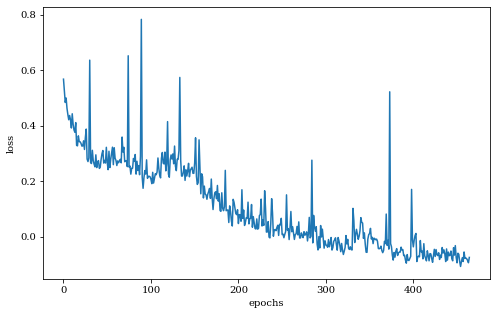

In [26]:
fig, ax = plt.subplots(1, figsize=(8,5))
loss_list = np.array(models['loss_list'])
loss_list = loss_list
ax.plot(loss_list)
print(loss_list)
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
fig.savefig('plots/loss_shapeworld4.png', format="png")


### lr rates for slot attention module

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

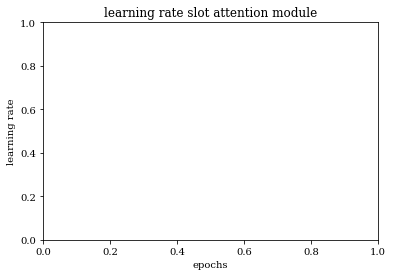

In [ ]:
lr_list = np.array( models['lr_list'])
epochs = lr_list[:,1]
lr=np.stack(lr_list[:,0])

fig1, ax1 = plt.subplots()


#fig = plt.figure()  
ax1.set_title("learning rate slot attention module")
ax1.set_ylabel("learning rate")
ax1.set_xlabel("epochs")


ax1.plot(epochs, lr[:,1])

fig1.savefig('plots/learning_rate.svg', format="svg")
plt.show()


# OLD 


# Model comparison

### Average Precision


FileNotFoundError: [Errno 2] No such file or directory: 'data/most_prob_pd_endtoend/slash_slot_models.pt'

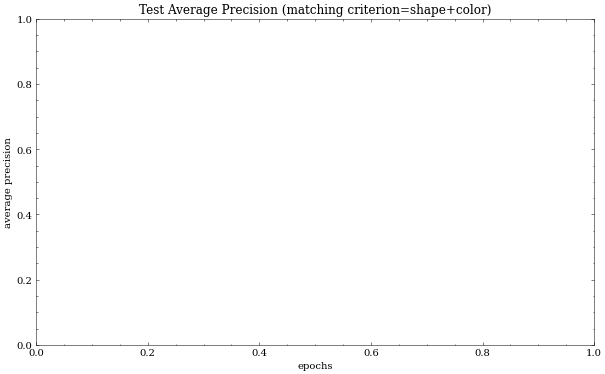

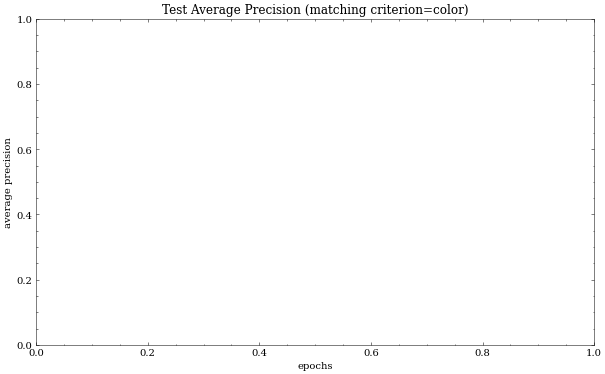

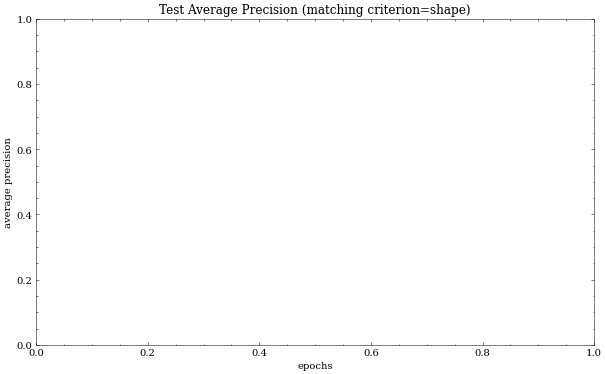

In [ ]:
model_paths = ["most_prob_pd_endtoend", "most_prob_bt_endtoend", "most_prob_pd_pretrained" , "most_prob_bt_pretrained"]



fig1, ax1 = plt.subplots(figsize=(10,6))
fig2, ax2 = plt.subplots(figsize=(10,6))
fig3, ax3 = plt.subplots(figsize=(10,6))

#fig = plt.figure()  
ax1.set_title("Test Average Precision (matching criterion=shape+color)")
ax1.set_ylabel("average precision")
ax1.set_xlabel("epochs")
ax2.set_title("Test Average Precision (matching criterion=color)")
ax2.set_ylabel("average precision")
ax2.set_xlabel("epochs")
ax3.set_title("Test Average Precision (matching criterion=shape)")
ax3.set_ylabel("average precision")
ax3.set_xlabel("epochs")


for mp in model_paths:
    model_path = "data/"+mp+"/slash_slot_models.pt" 
    models = torch.load(model_path)

    test_ap_list = models['test_ap_list']
    
    print(models['time'][0], mp)
    test_ap_list= np.array(test_ap_list)
    
    style="-"
    if models['exp_dict']['structure'] == 'poon-domingos':
        style="--"
    #print(test_ap_list.shape)
    x= 350


    ax1.plot(test_ap_list[:x,3], test_ap_list[:x,0],style, label=mp)    
    ax2.plot(test_ap_list[:x,3], test_ap_list[:x,1],style, label=mp)    
    ax3.plot(test_ap_list[:x,3], test_ap_list[:x,2],style, label=mp)    

    ax1.legend()
    ax2.legend()
    ax3.legend()

    fig1.savefig('plots/ap.svg', format="svg")
    fig2.savefig('plots/ap_color.svg', format="svg")
    fig3.savefig('plots/ap_shape.svg', format="svg")

    
plt.show()

In [ ]:
### log likelihoods

In [ ]:
model_paths = ["most_prob_pd_endtoend", "most_prob_bt_endtoend", "most_prob_pd_pretrained" , "most_prob_bt_pretrained"]



fig1, ax1 = plt.subplots(figsize=(10,6))
fig2, ax2 = plt.subplots(figsize=(10,6))
fig3, ax3 = plt.subplots(figsize=(10,6))

#fig = plt.figure()  
ax1.set_title("Test Average Precision (matching criterion=shape+color)")
ax1.set_ylabel("average precision")
ax1.set_xlabel("epochs")
ax2.set_title("Test Average Precision (matching criterion=color)")
ax2.set_ylabel("average precision")
ax2.set_xlabel("epochs")
ax3.set_title("Test Average Precision (matching criterion=shape)")
ax3.set_ylabel("average precision")
ax3.set_xlabel("epochs")


for mp in model_paths:
    model_path = "data/"+mp+"/slash_slot_models.pt" 
    models = torch.load(model_path)

    test_ap_list = models['test_ap_list']
    test_ap_list= np.array(test_ap_list)
    
    style="-"
    if models['exp_dict']['structure'] == 'poon-domingos':
        style="--"
    print(test_ap_list.shape)
    x= 350


    ax1.plot(test_ap_list[:x,3], test_ap_list[:x,0],style, label=mp)    
    ax2.plot(test_ap_list[:x,3], test_ap_list[:x,1],style, label=mp)    
    ax3.plot(test_ap_list[:x,3], test_ap_list[:x,2],style, label=mp)    

    ax1.legend()
    ax2.legend()
    ax3.legend()
plt.show()

# true positives

In [ ]:
"""
test_metric_list.append([true_positives, false_positives, true_negatives,correctly_classified,
                         true_positives_c, false_positives_c, true_negatives_c, correctly_classified_c,
                         true_positives_s, false_positives_s, true_negatives_s, correctly_classified_s])
"""

model_path = "data/most_prob_pd_endtoend/slash_slot_models.pt" 
models = torch.load(model_path)

print(models.keys())


test_metric_list = np.array(models['test_metric_list'])

correctly_classified =  test_metric_list[:350,3]
correctly_classified_color =  test_metric_list[:350,7]
correctly_classified_shape =  test_metric_list[:350,11]



fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title("Number of correctly classified samples on test set (5000 samples)")
ax1.set_ylabel("# correctly classified samples")
ax1.set_xlabel("epochs")

ax1.plot(correctly_classified,style, label="color+shape")
ax1.plot(np.argmax(correctly_classified), np.max(correctly_classified), 'r*')

ax1.plot(correctly_classified_color,style, label="color")
ax1.plot(np.argmax(correctly_classified_color), np.max(correctly_classified_color), 'r*')

ax1.plot(correctly_classified_shape, style, label="shape")
ax1.plot(np.argmax(correctly_classified_shape), np.max(correctly_classified_shape), 'r*')


ax1.legend()


fig1.savefig('plots/correctly_classified.svg', format="svg")


print(max_value, max_index)
plt.plot()